<font color=gray>Demo Notebook.

Copyright (c) 2020 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Training a Time Series Model with I-94 Traffic Data  </font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> OCI Data Science Team </font></p>

***

# Introduction

We are going to use the Oracle Cloud Infrastructure Data Science service to solve a real-world problem.  We are going to use a time series model to predict the number of vehicles on the road.  OCI Data Science allows users to work on data scienee problems in a jupyter notebook environment.  Data can be uploaded from a variety of sources from Oracle Cloud Object Storage, ADW, local machine,  and even other cloud providers.  In this example, we are going to pull data fromn Object Storage and use a couple of open source tools Statsmodel and Prophet to build the time series models.  After that, we are going to save a model to the Model Catalog.

## Dataset

We are going to use the I-94 traffic data set (https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) which contains hourly traffic volume on the  Interstate 94 Westbound traffic taken by the Minnesota Department of Transportation station 301 which is approximately midway between Minneapolis and St. Paul. We are going to build a model to predict the traffic volume so user traveling on this route can determine whether traffic is expected to be high, medium or low at travel time.

In [379]:
import ads
import pandas as pd
from fbprophet import Prophet
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import dask.dataframe as dd
from zipfile import ZipFile 
import os
from ads.dataset.factory import DatasetFactory
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Loading the dataset 

The dataset is a csv file stored in the Oracle Cloud Infrastructure Object Storage.  We are using a pre-authenticated request URL to access the data.


In [4]:
if not os.path.exists("./data/time_series_data.zip"): 
    if not os.path.exists("./data"): 
        os.mkdir("./data")
    data_url = 'https://objectstorage.us-ashburn-1.oraclecloud.com/p/OC6xNivOVcQva_qxWhvmyAlu4pisaIbAk-wjzdEma9s/n/bigdatadatasciencelarge/b/demo_material/o/time_series_data.zip'
    urllib.request.urlretrieve(data_url, filename = './data/time_series_data.zip')

with ZipFile("./data/time_series_data.zip", 'r') as zipf: 
    zipf.extractall("./data/")

In [5]:
data = pd.read_csv("/home/datascience/block_storage/data/time_series_data/Metro_Interstate_Traffic_Volume_Edit.csv")

0

In [6]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### Descriptions of the features:

1. holiday Categorical US National holidays plus regional holiday, Minnesota State Fair
2. temp Numeric Average temp in kelvin
3. rain_1h Numeric Amount in mm of rain that occurred in the hour
4. snow_1h Numeric Amount in mm of snow that occurred in the hour
5. clouds_all Numeric Percentage of cloud cover
6. weather_main Categorical Short textual description of the current weather
7. weather_description Categorical Longer textual description of the current weather
8. date_time DateTime Hour of the data collected in local CST time
9. traffic_volume Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [7]:
data['ds'] = pd.to_datetime(data["date_time"])

### Visualize Dataset

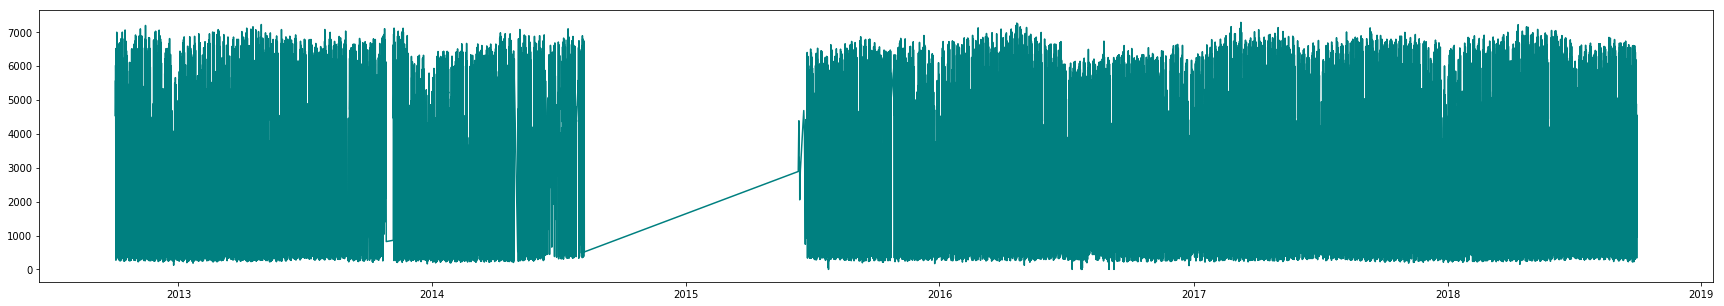

In [15]:
plt.rcParams['figure.figsize'] = [30, 5]
plt.plot(data['ds'], data['traffic_volume'])
plt.show()

#### It is a bit hard to see with so much data.  There is missing data in 2015.  Let's plot the data from 2017

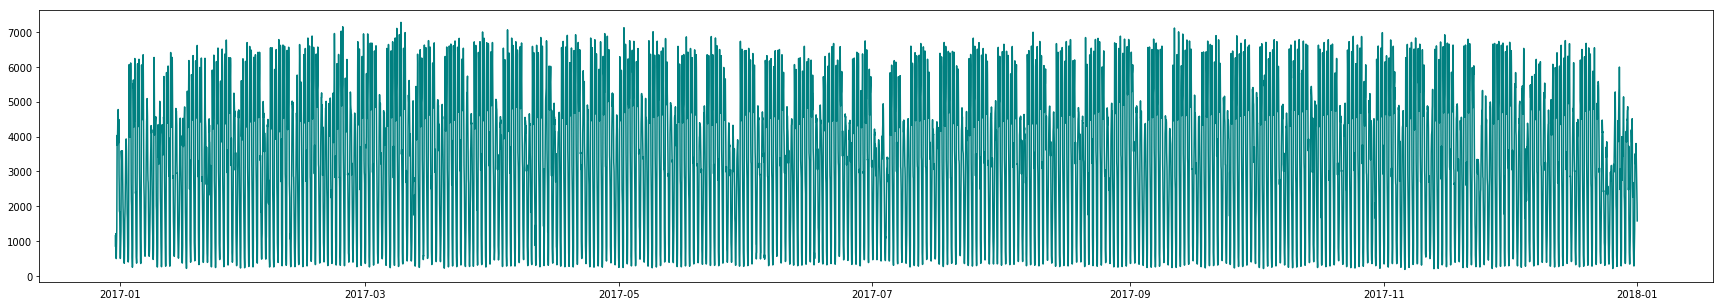

In [16]:
data_2017 = data[(data['date_time']>'2016-12-31') & (data['date_time']<'2018-01-01')]
plt.plot(data_2017['ds'], data_2017['traffic_volume'])
plt.show()

In [147]:
data_2017['traffic_volume'].sum()

29484694

In [148]:
data_2016 = data[(data['date_time']>'2015-12-31') & (data['date_time']<'2017-01-01')]

In [149]:
data_2016['traffic_volume'].sum()

25084532

#### Let's look at the data for the month of 01/2017

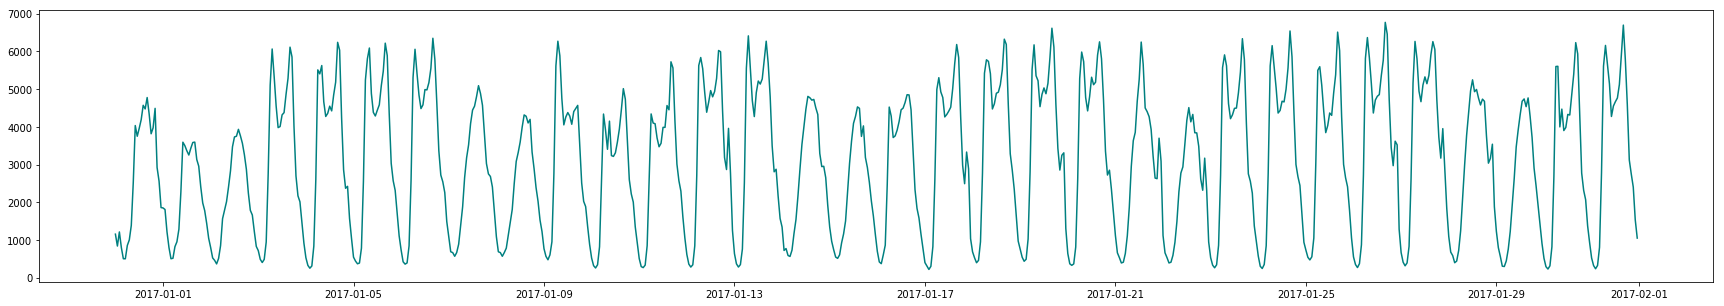

In [17]:

plt.rcParams['figure.figsize'] = [30, 5]
data_01_2017 = data[(data['date_time']>'2016-12-31') & (data['date_time']<'2017-02-01')]
plt.plot(data_01_2017['ds'], data_01_2017['traffic_volume'])
plt.show()

#### Let's look at the data for a single day

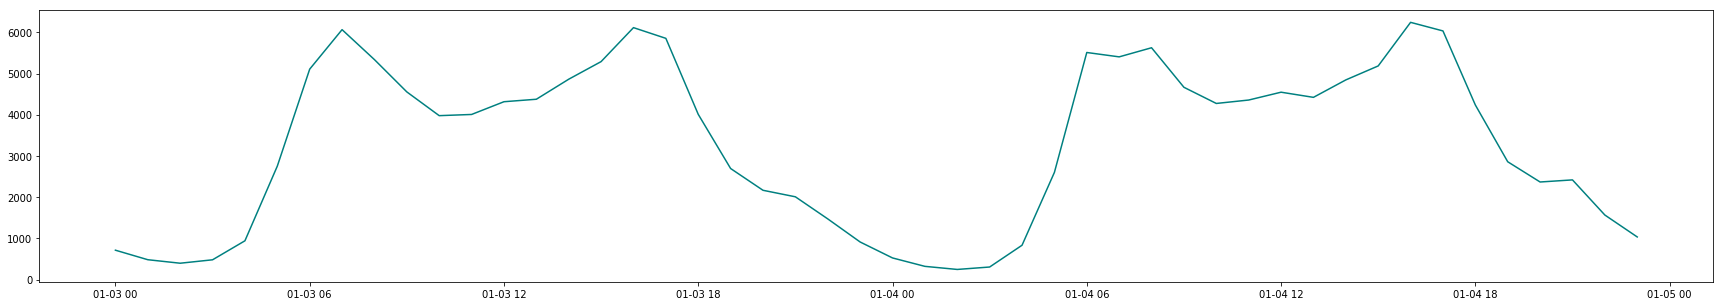

In [18]:

plt.rcParams['figure.figsize'] = [30, 5]
data_01_03_2017 = data[(data['date_time']>'2017-01-03') & (data['date_time']<'2017-01-05')]
plt.plot(data_01_03_2017['ds'], data_01_03_2017['traffic_volume'])
plt.show()

#### Let's check the number of time each type of weather is observed

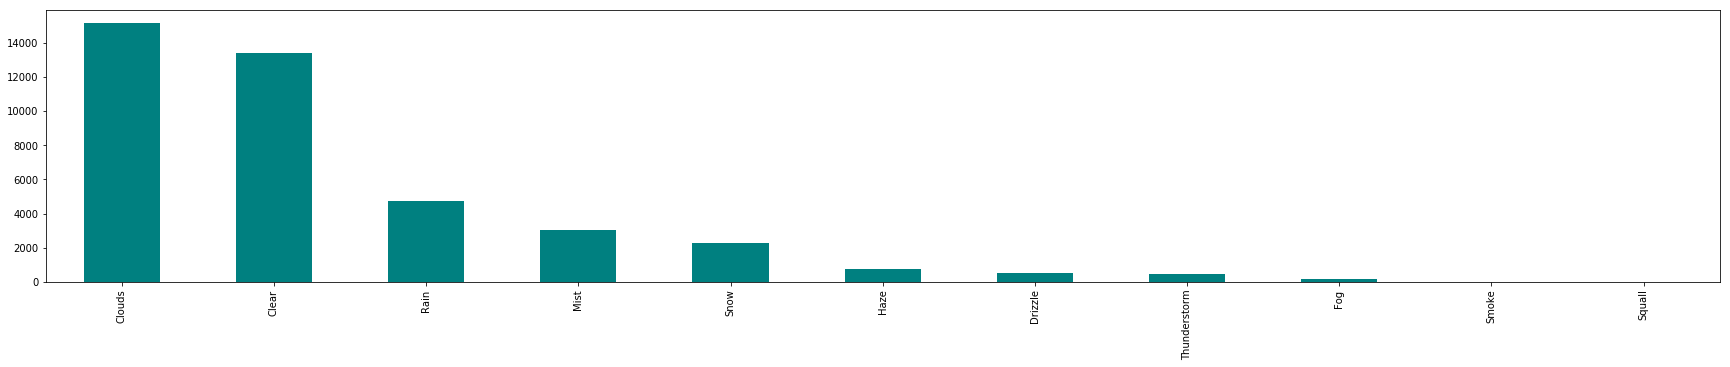

In [19]:
data["weather_main"].value_counts().plot.bar()
plt.show()

In [20]:
data['weekday'] = data.ds.dt.weekday
data['date'] = data.ds.dt.date
data['hour'] = data.ds.dt.hour
data['month'] = data.ds.dt.month
data['year'] = data.ds.dt.year
#Monday is 0 and Sunday is 6

### Let's plot the traffic volume on the different days of the week
0 = Monday
6 = Sunday

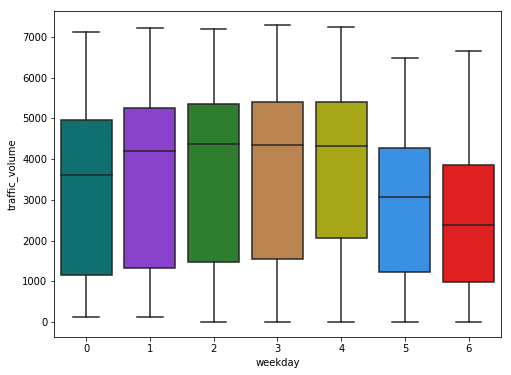

In [21]:
plt.figure(figsize=(8,6))
sns.boxplot(x='weekday', y='traffic_volume', data = data)
plt.show()

### Using Accelerated Data Science (ADS) library to Explore Dataset

The Accelerated Data Science (ADS) library allows easy exploration and visualization of the dataset

In [22]:
traffic_ds = DatasetFactory.open(data)


In [23]:
traffic_ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: ADSDataset</h3><h3>40,575 Rows, 15 Columns</h3><h4>Column Types:</h4…

In [319]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,ds,weekday,date,hour,month,year,y,is_weather_good
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,2012-10-02 09:00:00,1,2012-10-02,9,10,2012,5545,1
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,2012-10-02 10:00:00,1,2012-10-02,10,10,2012,4516,1
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,2012-10-02 11:00:00,1,2012-10-02,11,10,2012,4767,1
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,2012-10-02 12:00:00,1,2012-10-02,12,10,2012,5026,1
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,2012-10-02 13:00:00,1,2012-10-02,13,10,2012,4918,1


In [ ]:
data.groupby

In [ ]:
df.groupby(["state", "gender"])["last_name"].count()

### Training data and testing data

Let's use data from 2016 and 2017 to train the model.  We will use the model to predict the hourly vehicle volume for the first week of 2018 1/1/18 - 1/7/18.  We are going to use the Dickey-Fuller test to test whether the dataset is stationary

In [24]:

data_subset = data[(data['date_time']>'2016-01-01') & (data['date_time']<'2018-01-01')]
data_subset = data_subset.reset_index(drop = True)

In [25]:
data_test = data[(data['date_time']>'2018-01-01') & (data['date_time']<'2018-01-08')]


In [26]:
from statsmodels.tsa.stattools import adfuller
X = data_subset['traffic_volume'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.648935
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


### Dataset seems to be staionary.  Let's identify the parameters for the ARIMA model, p,d,q.  We will use the autocorrelation and partial autocorrelation plots.

In [27]:
training_data_statsmodel = data_subset[['ds', 'traffic_volume']]
testing_data_statsmodel = data_test[['ds', 'traffic_volume']]

In [28]:
training_data_statsmodel = training_data_statsmodel.set_index('ds')
training_data_statsmodel.index = pd.DatetimeIndex(training_data_statsmodel.index).to_period('H')
testing_data_statsmodel = testing_data_statsmodel.set_index('ds')
testing_data_statsmodel.index = pd.DatetimeIndex(testing_data_statsmodel.index).to_period('H')

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

### Look at the partial autocorrelation plot


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.




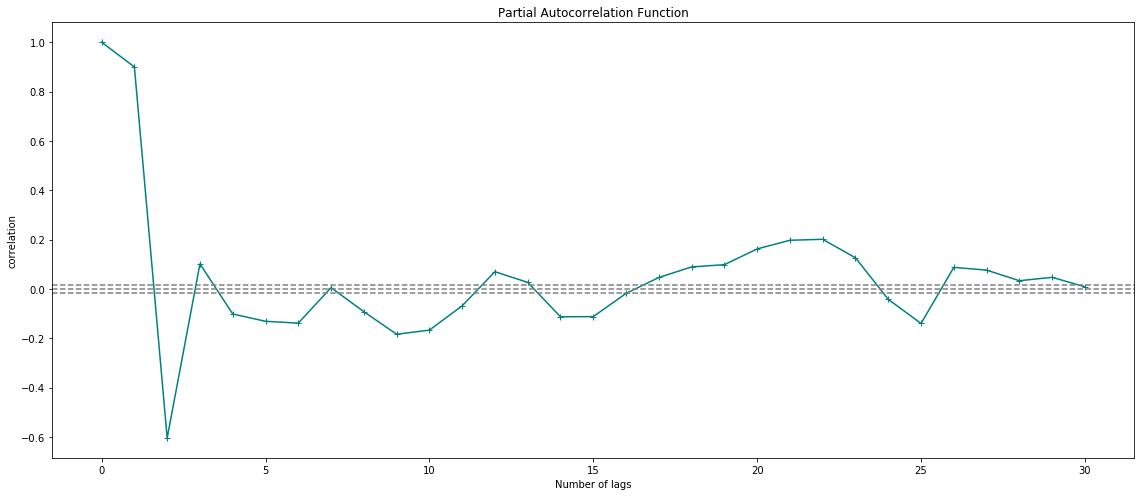

In [34]:
#calling partial correlation function
lag_pacf = pacf(training_data_statsmodel['traffic_volume'], nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(training_data_statsmodel['traffic_volume'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(training_data_statsmodel['traffic_volume'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

### Look at Autocorrelation plot


fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.




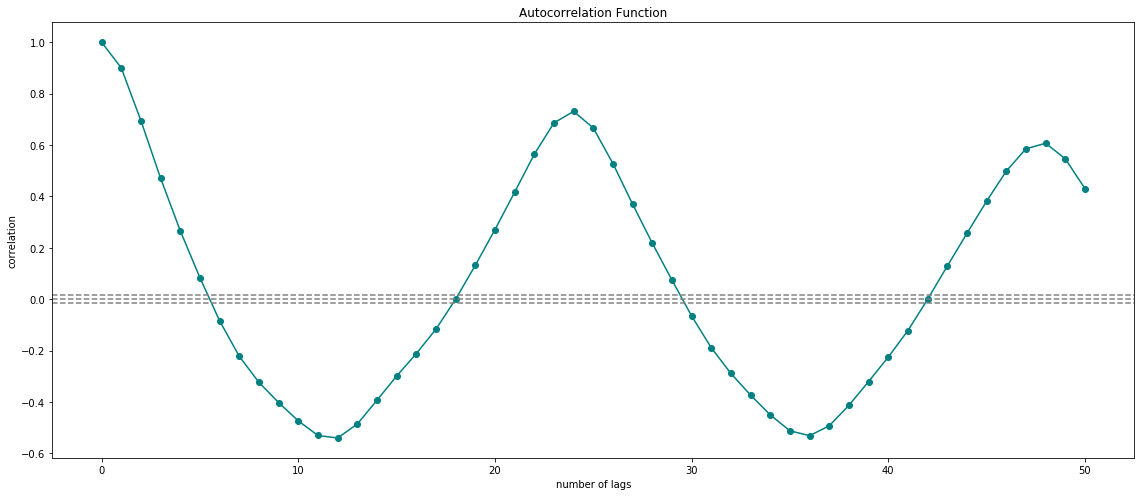

In [37]:
#calling acf function from stattools
lag_acf = acf(training_data_statsmodel['traffic_volume'], nlags=50)
plt.figure(figsize=(16, 7))
#Plot ACF: 
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(training_data_statsmodel['traffic_volume'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(training_data_statsmodel['traffic_volume'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [39]:
training_data_statsmodel

,traffic_volume
ds,
2016-01-01 00:00,1513
2016-01-01 01:00,1550
2016-01-01 03:00,719
2016-01-01 04:00,533
2016-01-01 05:00,586


In [42]:
arima_model = ARIMA(training_data_statsmodel, order=(2,0,6)).fit()

In [43]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:         traffic_volume   No. Observations:                16551
Model:                     ARMA(2, 6)   Log Likelihood             -130133.897
Method:                       css-mle   S.D. of innovations            628.607
Date:                Wed, 04 Mar 2020   AIC                         260287.794
Time:                        23:57:34   BIC                         260364.936
Sample:                    01-01-2016   HQIC                        260313.266
                         - 12-31-2017                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3289.9767     18.540    177.452      0.000    3253.639    3326.315
ar.L1.traffic_volume     1.9282      0.001   2634.953      0.000       1.927       1.930
ar.L2.traffi

### Look at the Mean Absolute Percentage Error of Model Prediction from ARIMA

In [44]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true))*100

In [45]:
mape_arima = mean_absolute_percentage_error(testing_data_statsmodel.loc['2018-01-01 00:00': '2018-01-07 23:00',:]['traffic_volume'].values,
                                   arima_model.forecast(168)[0])
print(mape_arima)

106.21063415455991


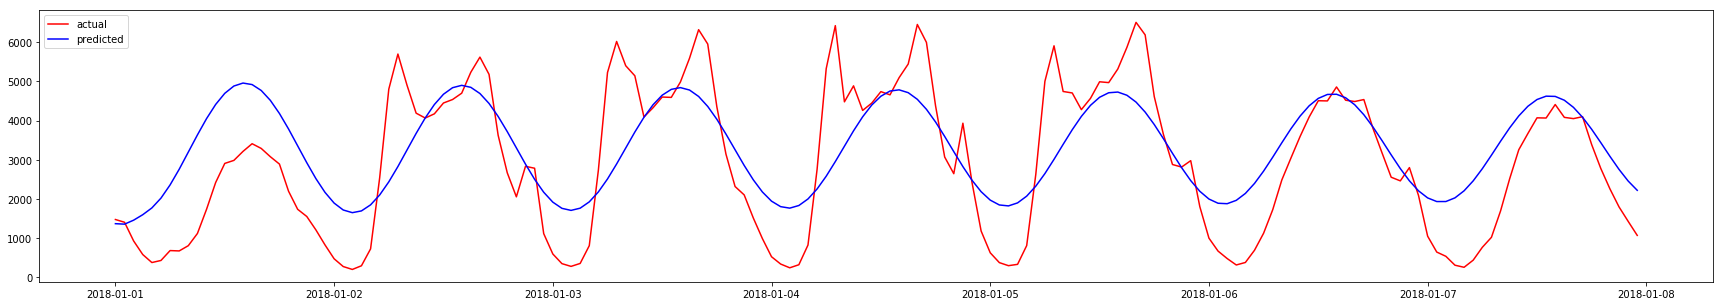

In [47]:
plt.plot(testing_data_statsmodel.index[0: 168].to_timestamp(), testing_data_statsmodel.loc['2018-01-01 00:00': '2018-01-07 23:00',:]['traffic_volume'].values, c= 'red', label = 'actual')
plt.plot(testing_data_statsmodel.index[0: 168].to_timestamp(),arima_model.forecast(168)[0], c= 'blue', label = 'predicted')
plt.legend(loc='upper left')
plt.show()

### Build Time Forecasting Model Using Facebook Prophet

Facebook Prophet is an open source tool for time series forecasting.  It is one of many open source packages pre-installed in the data science service.

Let's first transform the data to what Prophet expects with the timestamp  labeled as "ds" column and the target column labeled as "y"

In [50]:
data['y'] = data['traffic_volume']
data_subset = data[(data['date_time']>'2016-01-01') & (data['date_time']<'2018-01-01')]
data_subset = data_subset.reset_index(drop = True)

In [51]:
data_prophet = data_subset[['y','ds']]
data_prophet = data_prophet.reset_index(drop = True)

In [52]:
data_prophet.head()

,y,ds
0,1513,2016-01-01 00:00:00
1,1550,2016-01-01 01:00:00
2,719,2016-01-01 03:00:00
3,533,2016-01-01 04:00:00
4,586,2016-01-01 05:00:00


### Experiment

In [377]:
prophet=Prophet()
prophet.add_country_holidays(country_name='US')
prophet.fit(data_prophet)
future = prophet.make_future_dataframe(periods=168, freq='H')
forecast = prophet.predict(future)

In [378]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  50.71089982894564
Mean Absolute Error:  656.5336181040082


In [214]:
prophet2 = Prophet(holidays = holidays)
prophet2.add_seasonality(name = 'daily', period = 1, fourier_order = 10)
prophet2.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet2.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet2.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [215]:
future = prophet2.make_future_dataframe(periods=168, freq='H')
forecast = prophet2.predict(future)

In [216]:
#daily fourier order = 10
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.22449901712701
Mean Absolute Error:  419.5492708379287


In [213]:
#daily fourier order = 15
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  37.98180964371976
Mean Absolute Error:  419.6651899337852


In [210]:
#fourier order 7
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.31131738034521
Mean Absolute Error:  423.3020807022037


In [207]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.22449901712701
Mean Absolute Error:  419.5492708379287


In [204]:
#daily fourier order = 20
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.12835780314628
Mean Absolute Error:  419.8434803270727


In [228]:
prophet3 = Prophet(holidays = holidays, holidays_prior_scale=5)
prophet3.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet3.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet3.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet3.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [229]:
forecast = prophet3.predict(future)

In [230]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.07675472094241
Mean Absolute Error:  419.75167056450107


In [374]:
future_extended = prophet_holidays.make_future_dataframe(periods=336, freq='H')
forecast = prophet3.predict(future_extended)

In [375]:

del actual_predict_df
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-336:], actual_predict_df['yhat'][-336:])

Mean Absolute Percentage Error:  31.01772363799465
Mean Absolute Error:  411.7554465775947


In [248]:
prophet4 = Prophet(holidays = holidays, holidays_prior_scale=20)
prophet4.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet4.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet4.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet4.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [249]:
forecast = prophet4.predict(future)

In [250]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.11481568192714
Mean Absolute Error:  419.82013034661423


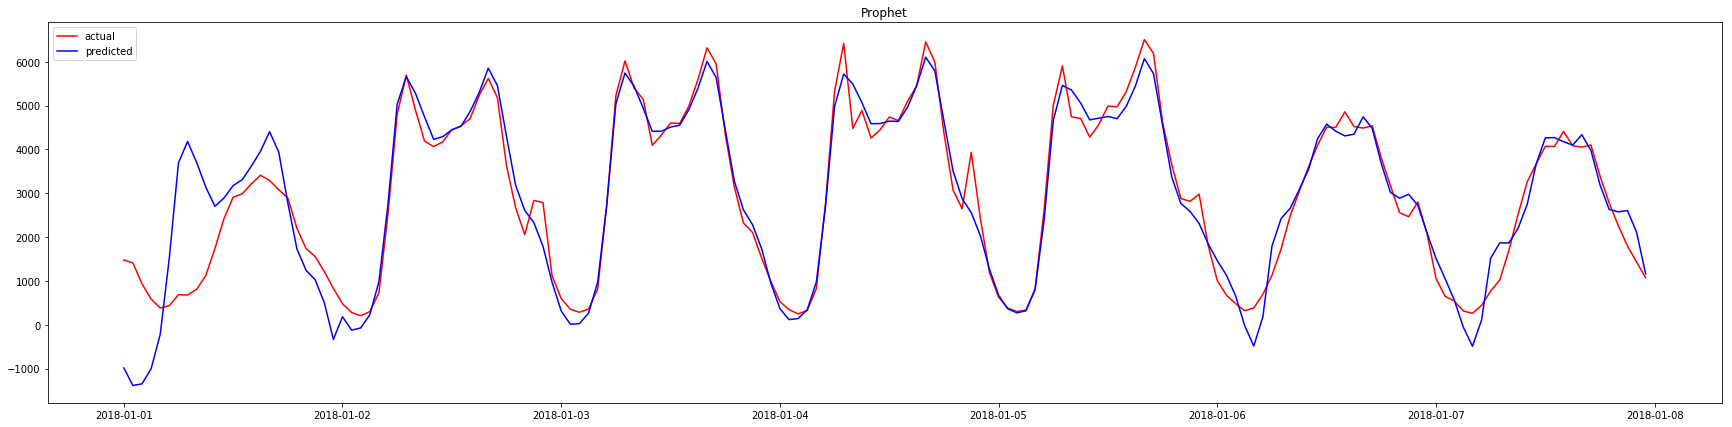

In [251]:
plot_actual_predict(data, forecast, 'Prophet')

In [256]:
prophet6 = Prophet(holidays = holidays, holidays_prior_scale=5)
prophet6.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet6.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet6.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet6.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [257]:
forecast = prophet6.predict(future)

In [258]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.07675472094241
Mean Absolute Error:  419.75167056450107


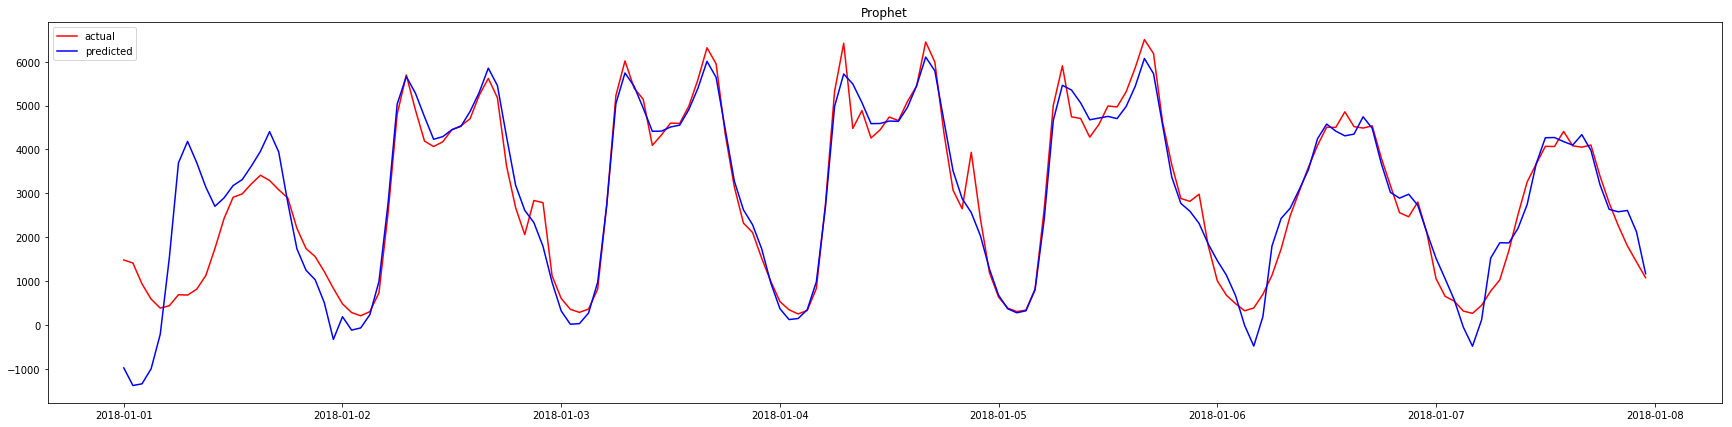

In [259]:
plot_actual_predict(data, forecast, 'Prophet')

In [252]:
prophet5 = Prophet(holidays = holidays, holidays_prior_scale=0.05)
prophet5.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet5.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet5.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet5.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [253]:
forecast = prophet5.predict(future)

In [254]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.22253693817411
Mean Absolute Error:  420.7260441465938


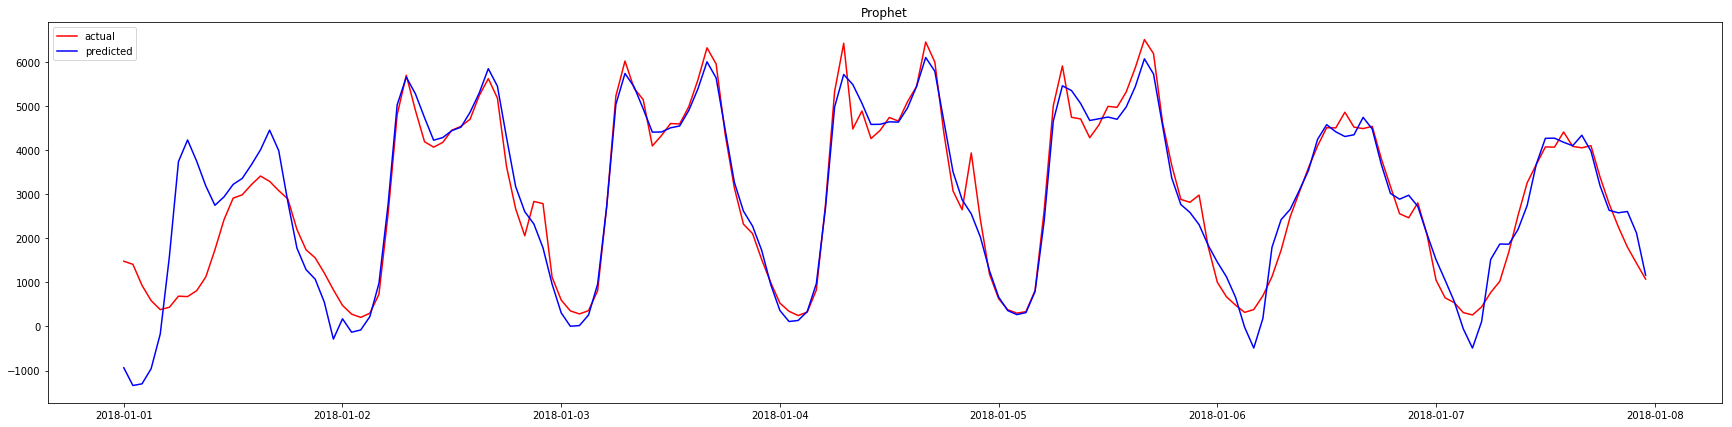

In [255]:
plot_actual_predict(data, forecast, 'Prophet')

In [260]:
prophet7 = Prophet(holidays = holidays)
prophet7.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet7.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
#prophet6.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet7.fit(data_prophet)

INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [261]:
forecast = prophet7.predict(future)

In [262]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  40.49174084202692
Mean Absolute Error:  433.40264254819493


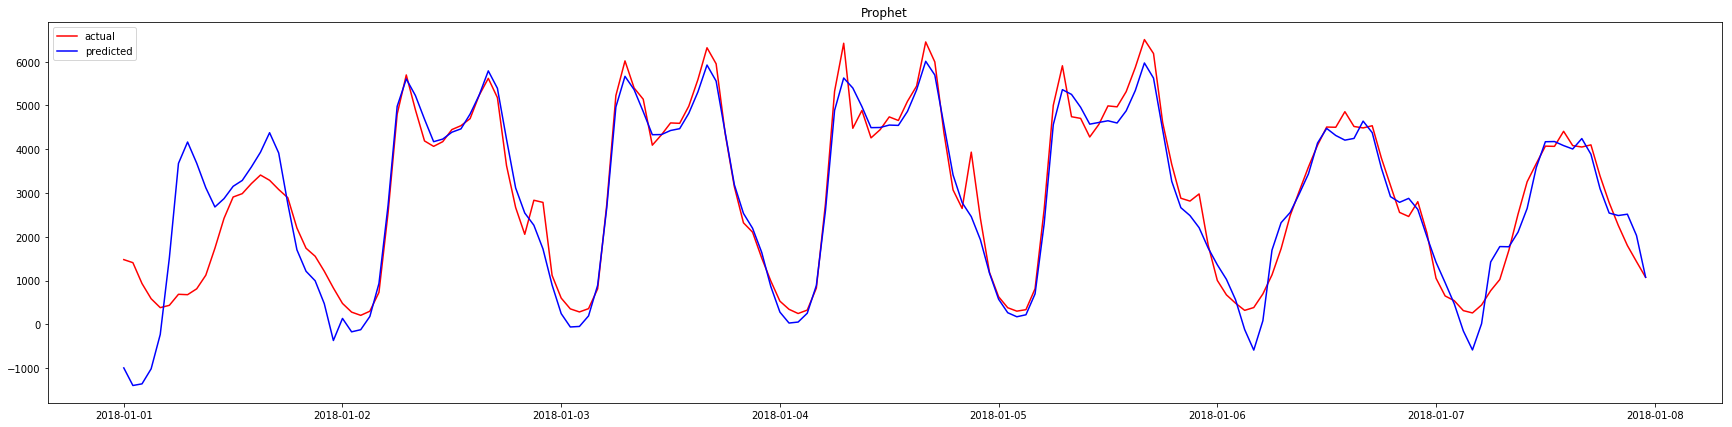

In [263]:
plot_actual_predict(data, forecast, 'Prophet')

In [284]:
#Try to add in saturation
prophet9 = Prophet(holidays = holidays, growth = 'logistic')
prophet9.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet9.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet9.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)


In [285]:
data_prophet_saturation = data_prophet
data_prophet_saturation['floor'] = 0
data_prophet_saturation['cap'] = 9000
prophet9.fit(data_prophet_saturation)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [286]:
future_saturation = future
future_saturation['cap'] = 9000
future_saturation['floor'] = 0

In [287]:
forecast_saturation = prophet9.predict(future_saturation)

In [367]:
future_saturation_extended = future_extended
future_saturation_extended['cap'] = 9000
future_saturation_extended['floor'] = 0

In [371]:
forecast_saturation_extended = prophet9.predict(future_saturation)

In [372]:
del actual_predict_df
actual_predict_df = pd.merge(forecast_saturation_extended, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-336:], actual_predict_df['yhat'][-336:])

Mean Absolute Percentage Error:  42.181414320714296
Mean Absolute Error:  539.3222320526842


In [292]:
#forecast_saturation['yhat']

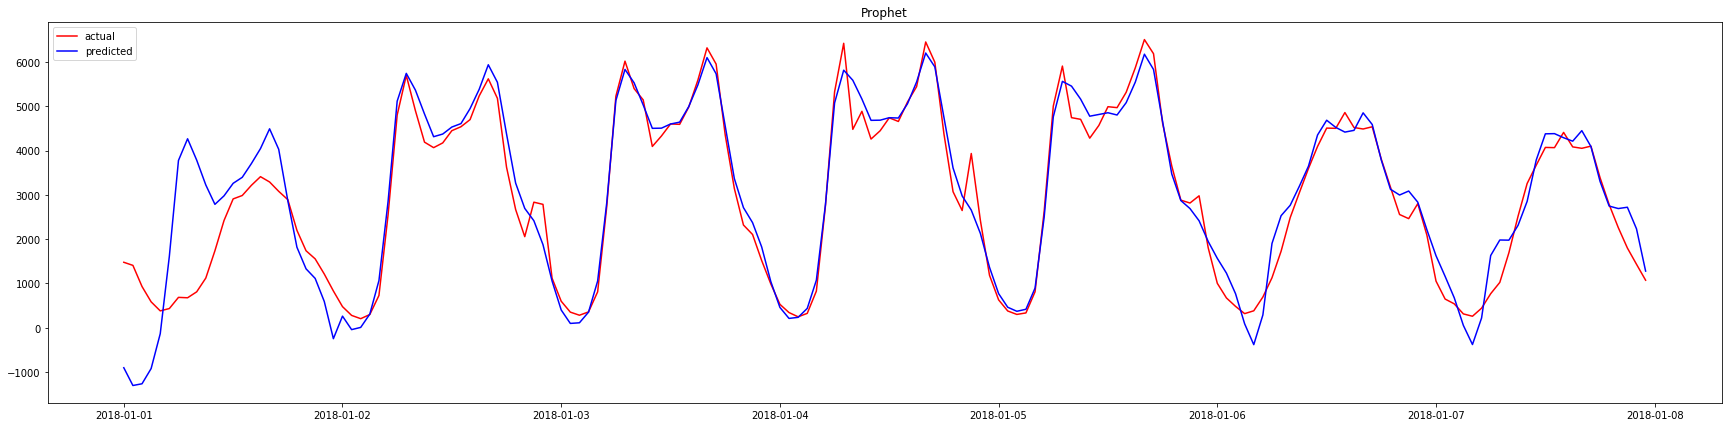

In [376]:
plot_actual_predict(data, forecast_saturation_extended, 'Prophet')

In [293]:
prophet10 = Prophet(growth = 'logistic')
prophet10.fit(data_prophet_saturation)
forecast_saturation = prophet10.predict(future_saturation)

In [303]:
del actual_predict_df
actual_predict_df = pd.merge(forecast_saturation, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  53.8561707808457
Mean Absolute Error:  703.7655009254592


In [298]:
forecast_saturation['yhat'].min()

-1294.8269522904093

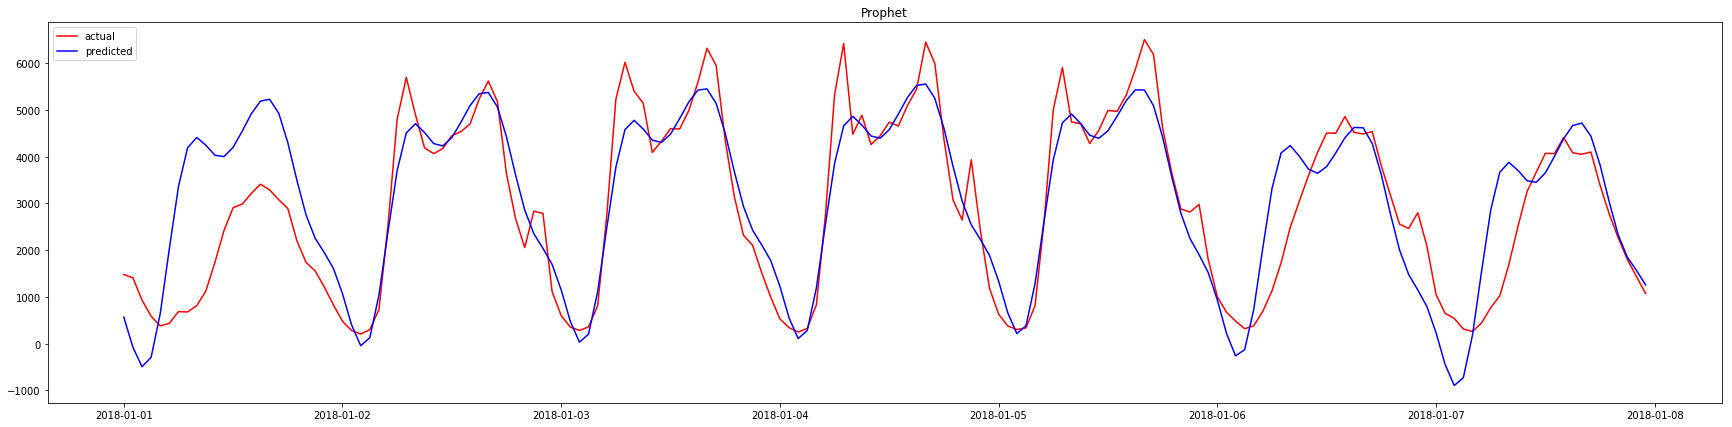

In [295]:
plot_actual_predict(data, forecast_saturation, 'Prophet')

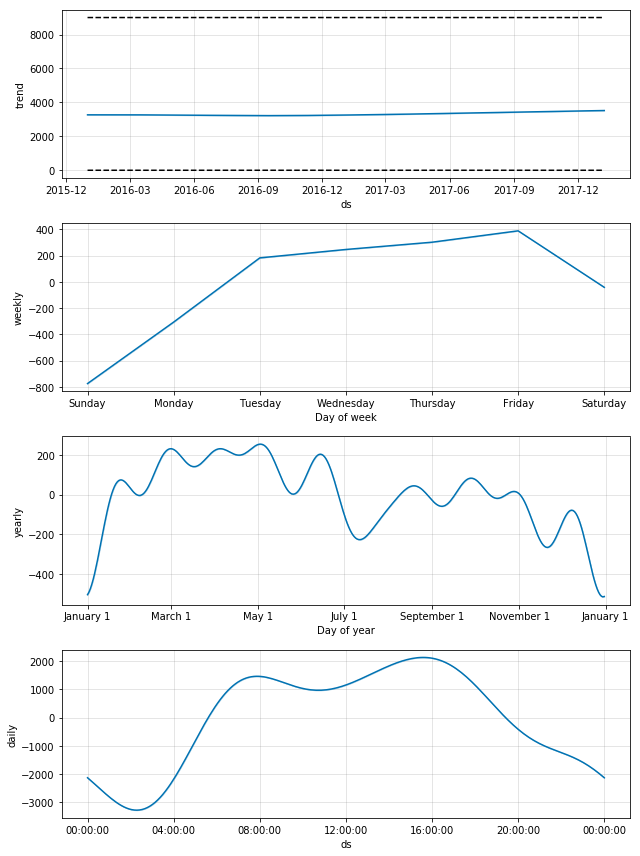

In [302]:
fig4 = prophet10.plot_components(forecast_saturation)

In [305]:
prophet11 = Prophet(holidays = holidays, growth = 'logistic')
prophet11.fit(data_prophet_saturation)
forecast_saturation = prophet11.predict(future_saturation)

In [306]:
del actual_predict_df
actual_predict_df = pd.merge(forecast_saturation, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  50.99106455360784
Mean Absolute Error:  645.5363118732362


In [313]:
##Try to add in saturation
prophet12 = Prophet(holidays = holidays, growth = 'logistic')
prophet12.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet12.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
#prophet9.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet12.fit(data_prophet_saturation)

INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [314]:
forecast_saturation = prophet12.predict(future_saturation)

In [315]:
del actual_predict_df
actual_predict_df = pd.merge(forecast_saturation, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  37.27274090688677
Mean Absolute Error:  423.06450244401174


In [316]:
prophet13 = Prophet(holidays = holidays, growth = 'logistic', seasonality_mode = 'multiplicative')
prophet13.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet13.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
#prophet9.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet13.fit(data_prophet_saturation)

INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [317]:
forecast_saturation = prophet13.predict(future_saturation)

In [343]:
future_saturation.head()

,ds,cap,floor
0,2016-01-01 00:00:00,9000,0
1,2016-01-01 01:00:00,9000,0
2,2016-01-01 03:00:00,9000,0
3,2016-01-01 04:00:00,9000,0
4,2016-01-01 05:00:00,9000,0


In [318]:
del actual_predict_df
actual_predict_df = pd.merge(forecast_saturation, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  41.185742957239704
Mean Absolute Error:  434.1649960499187


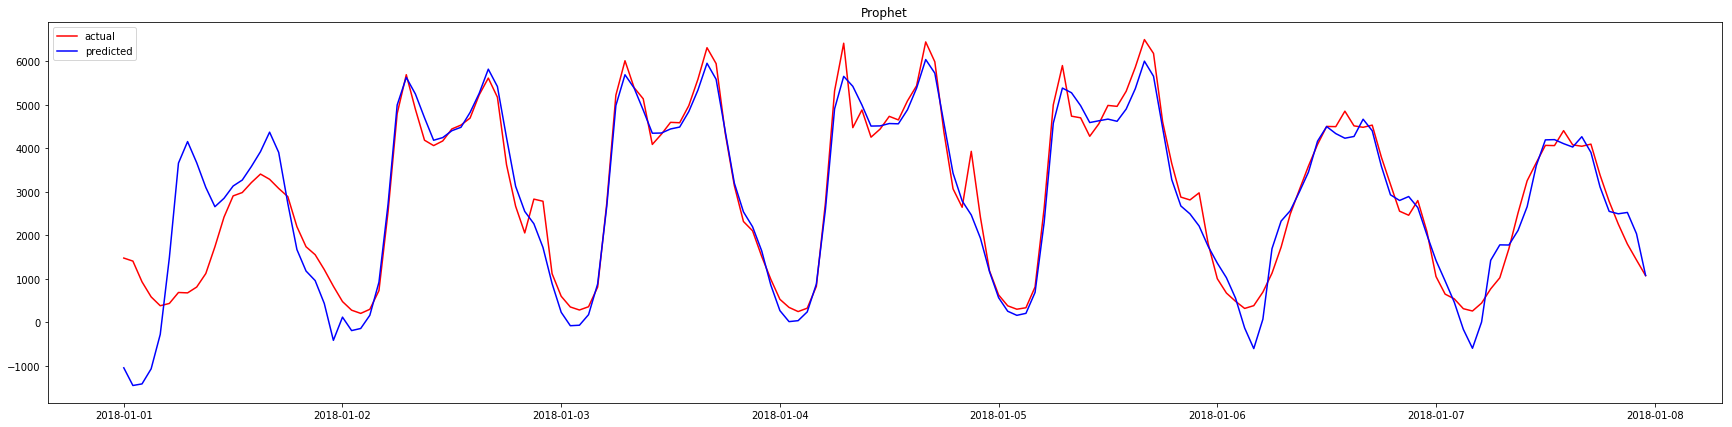

In [325]:
plot_actual_predict(data, forecast_saturation, 'Prophet')

In [333]:
data_prophet = data_prophet.drop(columns = ['floor','cap'] )

In [337]:
future = future.drop(columns=['cap', 'floor'])

In [341]:
#

In [344]:
prophet14 = Prophet(holidays = holidays, seasonality_mode = 'multiplicative')
prophet14.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet14.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet14.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet14.fit(data_prophet)
forecast = prophet14.predict(future)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [347]:
del actual_predict_df
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  36.53068613535253
Mean Absolute Error:  415.794179539302


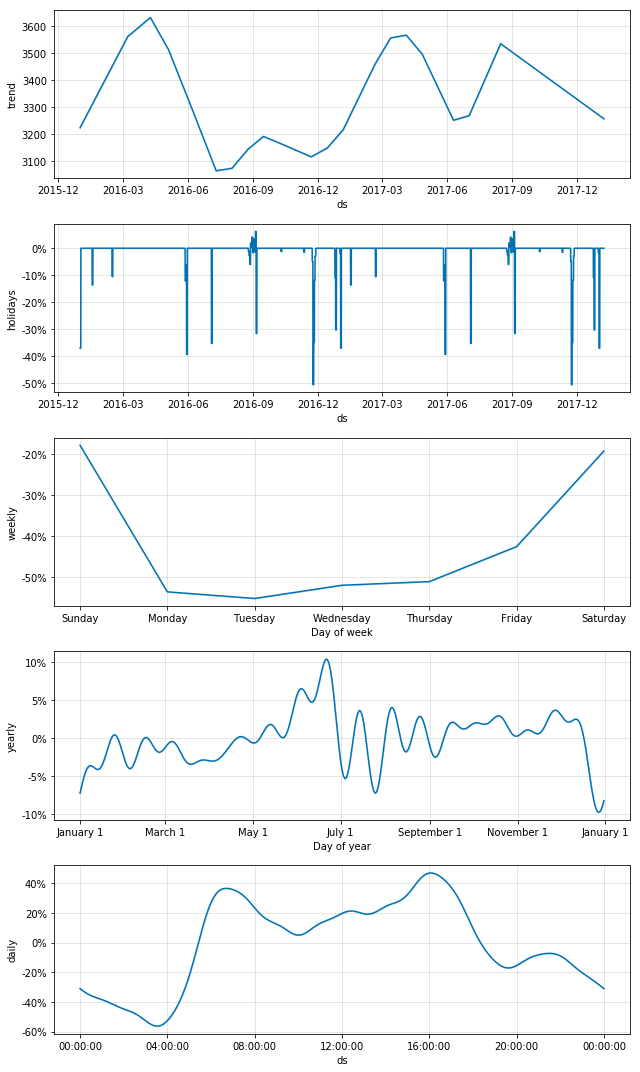

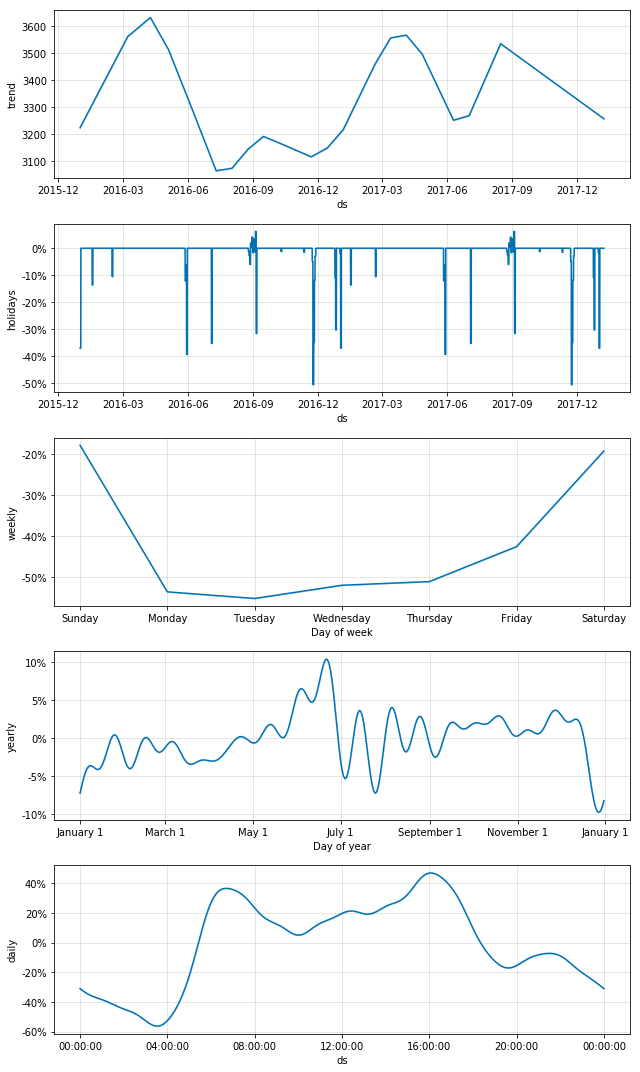

In [348]:
prophet14.plot_components(forecast)

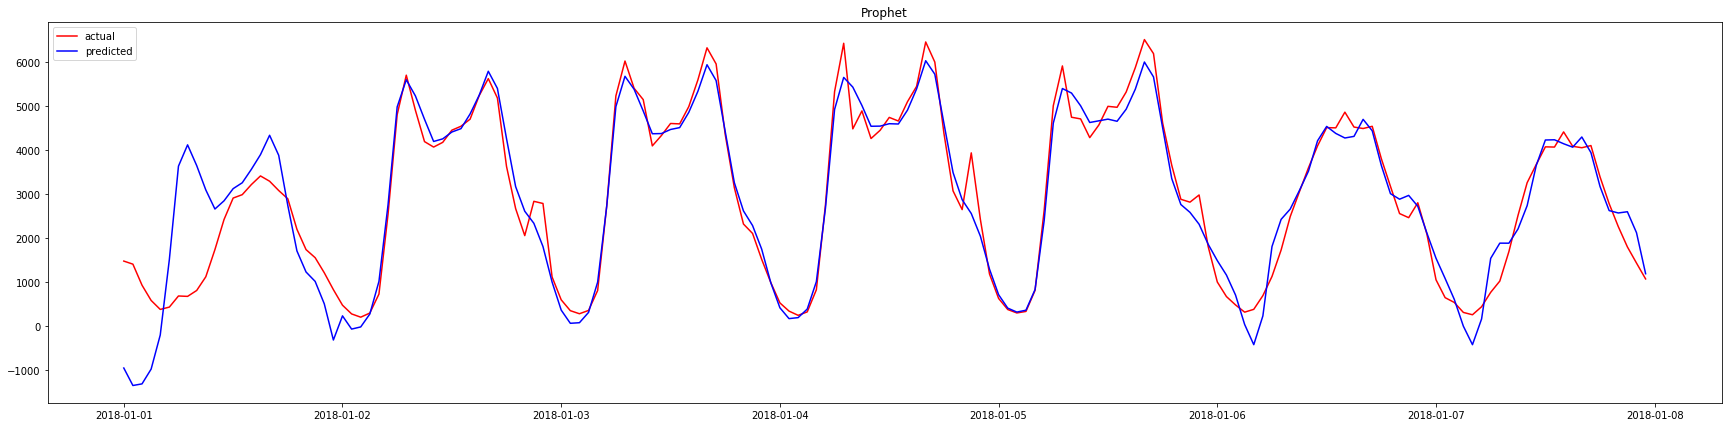

In [349]:
plot_actual_predict(data, forecast, 'Prophet')

In [350]:
prophet15 = Prophet(holidays = holidays, seasonality_mode = 'multiplicative')
prophet15.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet15.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
#prophet14.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet15.fit(data_prophet)
forecast = prophet15.predict(future)

INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [351]:
del actual_predict_df
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  37.41308290197144
Mean Absolute Error:  424.8708516821614


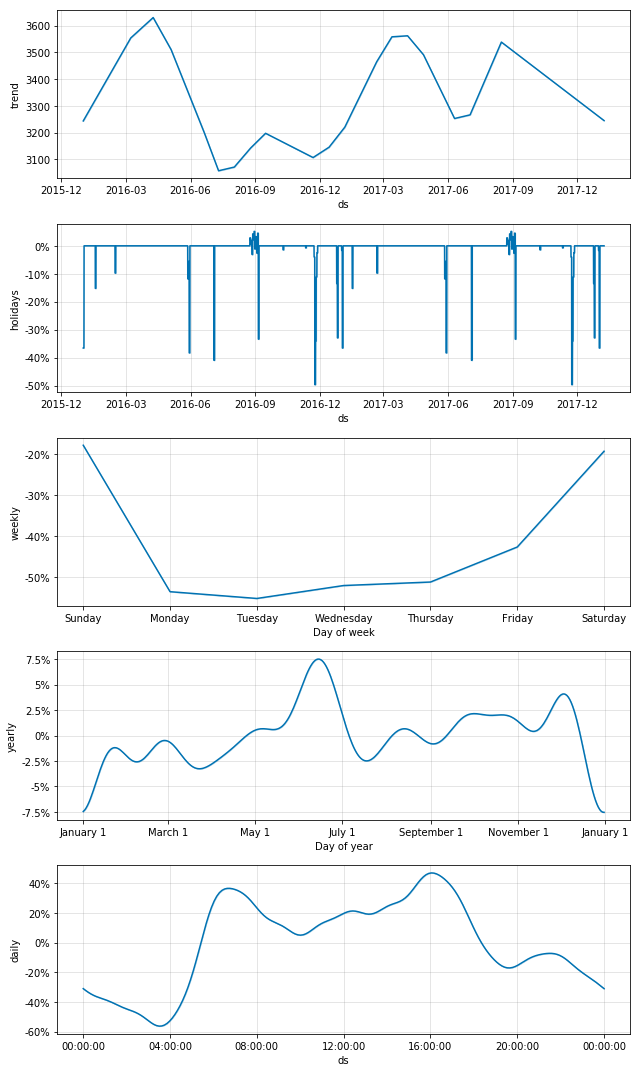

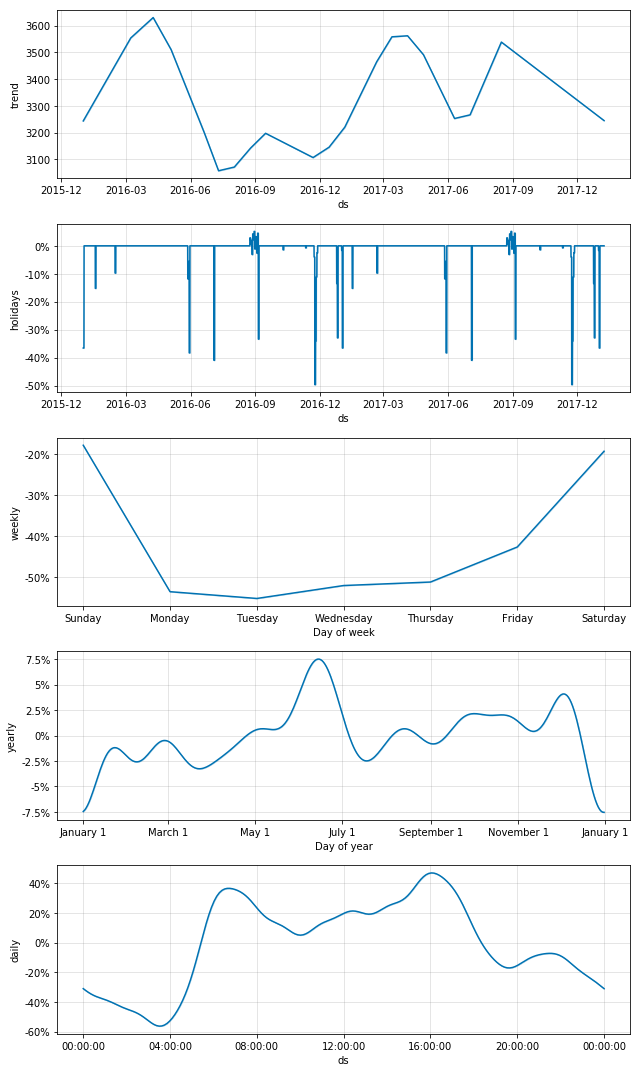

In [352]:
prophet15.plot_components(forecast)

In [361]:
prophet16 = Prophet(holidays = holidays, seasonality_mode = 'multiplicative', holidays_prior_scale=0.05)
prophet16.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet16.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet16.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet16.fit(data_prophet)
forecast = prophet16.predict(future)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [354]:
del actual_predict_df
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  36.53710948685774
Mean Absolute Error:  415.80305088004053


In [357]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01 00:00:00,3224.636070,-1175.305038,40.976604,3224.636070,3224.636070,0.0,0.0,0.0,0.0,...,-0.425681,-0.425681,-0.425681,-0.078543,-0.078543,-0.078543,0.0,0.0,0.0,-593.724502
1,2016-01-01 01:00:00,3224.844592,-1487.315441,-298.144922,3224.844592,3224.844592,0.0,0.0,0.0,0.0,...,-0.445335,-0.445335,-0.445335,-0.078213,-0.078213,-0.078213,0.0,0.0,0.0,-894.190938
2,2016-01-01 03:00:00,3225.261634,-1619.110140,-336.813239,3225.261634,3225.261634,0.0,0.0,0.0,0.0,...,-0.318065,-0.318065,-0.318065,-0.077550,-0.077550,-0.077550,0.0,0.0,0.0,-940.986752
3,2016-01-01 04:00:00,3225.470155,-1053.797478,123.564022,3225.470155,3225.470155,0.0,0.0,0.0,0.0,...,-0.174679,-0.174679,-0.174679,-0.077217,-0.077217,-0.077217,0.0,0.0,0.0,-476.513426
4,2016-01-01 05:00:00,3225.678677,483.411653,1674.077014,3225.678677,3225.678677,0.0,0.0,0.0,0.0,...,0.003223,0.003223,0.003223,-0.076883,-0.076883,-0.076883,0.0,0.0,0.0,1071.595169


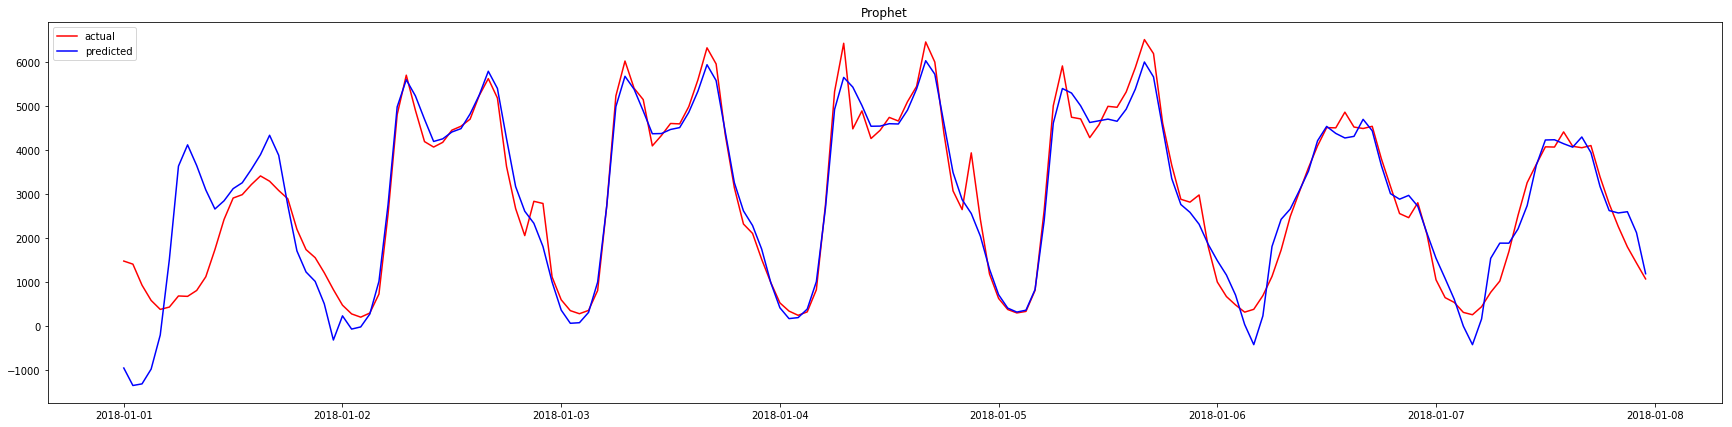

In [355]:
plot_actual_predict(data, forecast, 'Prophet')

In [362]:
future_extended = prophet_holidays.make_future_dataframe(periods=336, freq='H')

In [363]:
forecast = prophet16.predict(future_extended)

In [364]:
del actual_predict_df
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-336:], actual_predict_df['yhat'][-336:])

Mean Absolute Percentage Error:  30.080542372613873
Mean Absolute Error:  413.54988656289413


In [ ]:
# holidays_prior_scale=1
#Mean Absolute Percentage Error:  29.70310639258572
#Mean Absolute Error:  411.7091999825961

In [ ]:

# Python
df['y'] = 10 - df['y']
df['cap'] = 6
df['floor'] = 1.5
future['cap'] = 6
future['floor'] = 1.5

In [ ]:
# add in growth

In [151]:
prophet_holidays=Prophet(holidays = holidays, growth = 'linear')
prophet_holidays.fit(data_prophet)
forecast = prophet_holidays.predict(future)

In [152]:
actual_predict_df = pd.merge(forecast, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  49.64497124441546
Mean Absolute Error:  630.5399077295428


In [ ]:
prophet_holidays=Prophet(holidays = holidays, growth = 'linear')
prophet_holidays.fit(data_prophet)
forecast = prophet_holidays.predict(future)

### There is an option to include holidays as part of the seasonality

In [153]:
#There is an option to include holidays as part of the seasonality
holidays = pd.read_csv('/home/datascience/block_storage/data/time_series_data/usholidays.csv')
prophet_holidays=Prophet(holidays = holidays)
prophet_holidays.fit(data_prophet)

In [163]:
future = prophet_holidays.make_future_dataframe(periods=168, freq='H')

In [155]:
forecast = prophet_holidays.predict(future)

#### Below is a plot of the forecast In the forecast plot, the black dot represents the actual data.  The blue line represents the prediction from the model.  Light blue highlights the uncertainty.                                                               

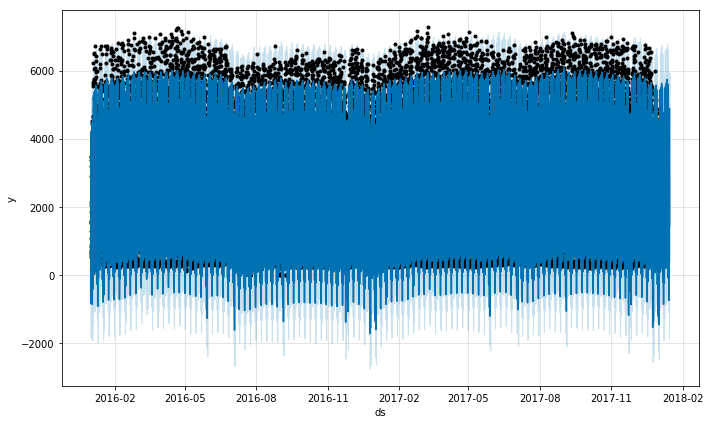

In [156]:
fig1 = prophet_holidays.plot(forecast)

#### Here are plots of the trend, yearly seasonality, and weekly seasonality of the time series

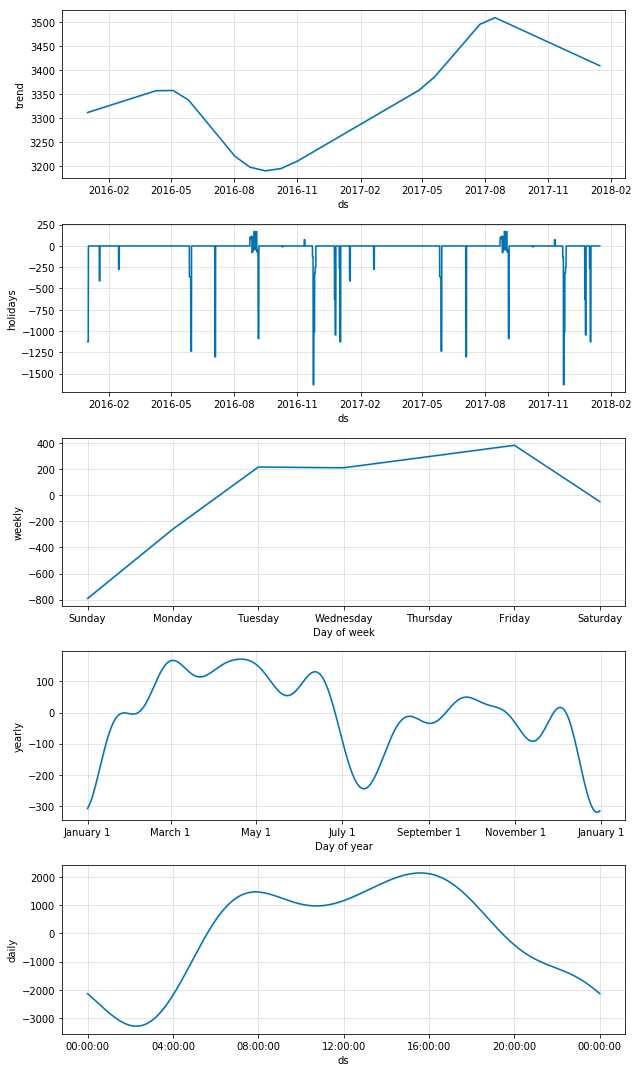

In [157]:
fig2 = prophet_holidays.plot_components(forecast)

### Plot actual vs predicted 

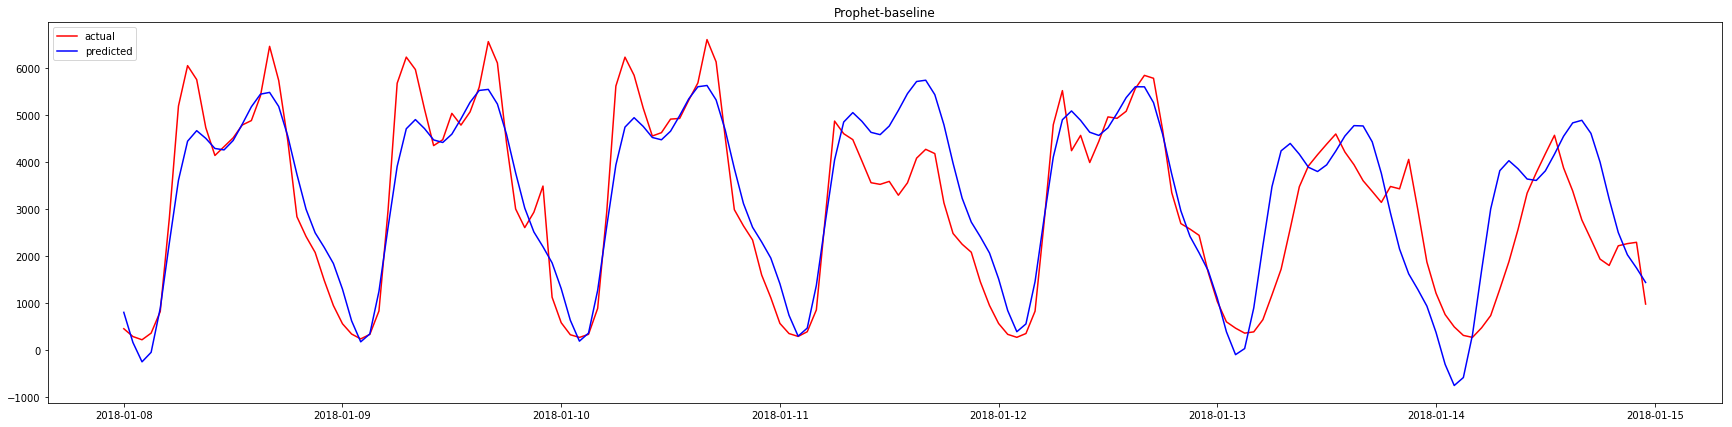

In [161]:
def plot_actual_predict(actual_dataset, forecast_dataset, title):    
    actual_predict_df = pd.merge(forecast_dataset, actual_dataset, how = 'inner', on = 'ds' )
    plt.figure(figsize=(30, 7))
    plt.plot(actual_predict_df['ds'][-168:], actual_predict_df['traffic_volume'][-168:], c= 'red', label = 'actual')
    plt.plot(actual_predict_df['ds'][-168:], actual_predict_df['yhat'][-168:], c= 'blue', label = 'predicted')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    
    
plot_actual_predict(data, forecast, 'Prophet-baseline')

### Look at the Errors: Mean Absolute Percentage Error of Model and Mean Absolut Error

In [160]:
def print_error(actual_dataset, forecast_dataset):
    mape = mean_absolute_percentage_error(actual_dataset, forecast_dataset)
    print('Mean Absolute Percentage Error: ', mape)
    print('Mean Absolute Error: ', mean_absolute_error(actual_dataset, forecast_dataset) )
    
print_error(actual_predict_df['traffic_volume'][-336:], actual_predict_df['yhat'][-336:])

Mean Absolute Percentage Error:  52.716684221605384
Mean Absolute Error:  677.004350006785


### Check out if there is an improvement with adding weekly seasonality

In [142]:
prophet_seasonality=Prophet(holidays = holidays, weekly_seasonality = True, daily_seasonality = True)
prophet_seasonality.fit(data_prophet)
forecast_seasonality = prophet_weekly_seasonality.predict(future)

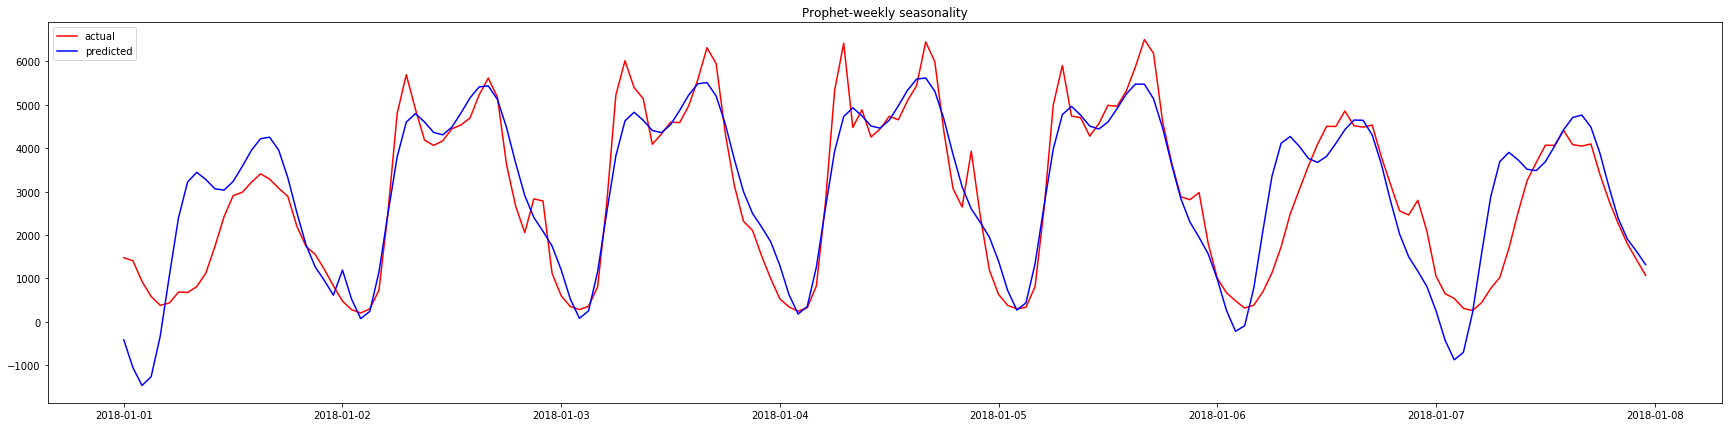

In [139]:
plot_actual_predict(data, forecast_weekly_seasonality, 'Prophet-weekly seasonality')

In [140]:
actual_predict_df = pd.merge(forecast_weekly_seasonality, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  49.64497124441546
Mean Absolute Error:  630.5399077295428


### One might expect that weather and tempearture can have an impact on traffic volume on the road.  It is possible to add in weather as a factor in Prophet

We will define the weather as good if it the weather column is marked as "Clear" or "Clouds".  The rest of the labels such as "Snow" or "Rain" are marked as not good. We will also add in temperature in the model.

In [62]:
def is_weather_good(x):
    if x == 'Clear' or x == 'Clouds':
        return 1
    else:
        return 0

In [63]:
data['is_weather_good'] = data['weather_main'].apply(is_weather_good)

In [187]:
data_subset = data[(data['date_time']>'2016-01-01') & (data['date_time']<'2018-01-01')]
#data_prophet_weather = data_subset[['y','ds', 'is_weather_good', 'temp']]
data_prophet_weather = data_subset[['y','ds', 'is_weather_good']]
#data_prophet_weather = data_prophet_weather.reset_index(drop = True)

In [188]:
future_weather = future.merge(data, on='ds')
#future_weather = future_weather[['ds', 'is_weather_good', 'temp']]
future_weather = future_weather[['ds', 'is_weather_good']]

In [ ]:
# prophet2 = Prophet(holidays = holidays)
# prophet2.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
# prophet2.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
# prophet2.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
# prophet2.fit(data_prophet)

In [192]:
prophet_weather= Prophet(holidays = holidays)
prophet_weather.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet_weather.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet_weather.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet_weather.add_regressor('is_weather_good')
#prophet_weather.add_regressor('temp')
prophet_weather.fit(data_prophet_weather)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [193]:
forecast_weather = prophet_weather.predict(future_weather)

In [195]:
actual_predict_df = pd.merge(forecast_weather, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  37.94546535189614
Mean Absolute Error:  418.26028609841694


In [197]:
future_weather = future.merge(data, on='ds')
future_temp= future.merge(data, on='ds')
#future_weather = future_weather[['ds', 'is_weather_good', 'temp']]
future_temp = future_weather[['ds', 'temp']]

In [198]:
data_subset = data[(data['date_time']>'2016-01-01') & (data['date_time']<'2018-01-01')]
#data_prophet_weather = data_subset[['y','ds', 'is_weather_good', 'temp']]
data_prophet_weather = data_subset[['y','ds', 'temp']]

In [199]:
prophet_temp= Prophet(holidays = holidays)
prophet_temp.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet_temp.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet_temp.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet_temp.add_regressor('temp')
#prophet_weather.add_regressor('temp')
prophet_temp.fit(data_prophet_weather)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [200]:
forecast_temp = prophet_temp.predict(future_temp)

In [201]:
actual_predict_df = pd.merge(forecast_temp, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.30946329492536
Mean Absolute Error:  420.73822099984386


In [222]:
data_subset = data[(data['date_time']>'2016-01-01') & (data['date_time']<'2018-01-01')]
#data_prophet_weather = data_subset[['y','ds', 'is_weather_good', 'temp']]
data_prophet_weather = data_subset[['y','ds', 'snow_1h']]

In [223]:
prophet_temp= Prophet(holidays = holidays)
prophet_temp.add_seasonality(name = 'daily', period = 1, fourier_order = 15)
prophet_temp.add_seasonality(name = 'weekly', period = 7, fourier_order = 20)
prophet_temp.add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20)
prophet_temp.add_regressor('snow_1h')
#prophet_weather.add_regressor('temp')
prophet_temp.fit(data_prophet_weather)

INFO:fbprophet:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet:Found custom seasonality named "daily", disabling built-in daily seasonality.


In [225]:

future_temp= future.merge(data, on='ds')
#future_weather = future_weather[['ds', 'is_weather_good', 'temp']]
future_temp = future_weather[['ds', 'snow_1h']]

In [226]:
forecast_temp = prophet_temp.predict(future_temp)

In [227]:
actual_predict_df = pd.merge(forecast_temp, data, how = 'inner', on = 'ds' )
print_error(actual_predict_df['traffic_volume'][-168:], actual_predict_df['yhat'][-168:])

Mean Absolute Percentage Error:  38.106986027438424
Mean Absolute Error:  419.83643788558436


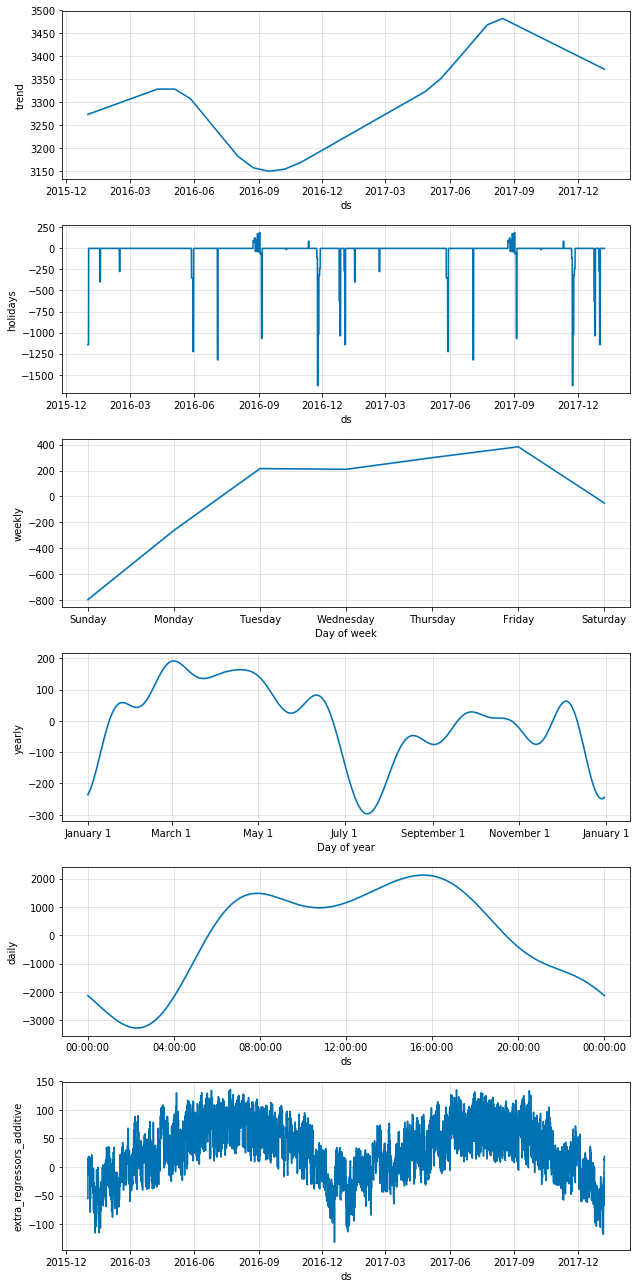

In [80]:
fig3 = prophet_weather.plot_components(forecast_weather)

### Look at the Mean Absolute Percentage Error of Model

In [185]:
mape_prophet_weather = \
mean_absolute_percentage_error(testing_data_statsmodel.loc['2018-01-01 00:00': '2018-01-07 23:00',:]['traffic_volume'].values,
                                   forecast_weather[(forecast_weather['ds']>'2017-12-31 23:00') & (forecast_weather['ds']<'2018-01-08 00:00')]['yhat'].to_numpy())

In [186]:
mape_prophet_weather

38.44955649550024

### Build Recurrent Neural Network for Time Series Forecasting

In [381]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [399]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 

In [418]:
lstm_train = data_subset[['ds', 'traffic_volume']]
lstm_train = lstm_train.reset_index(drop = True)
lstm_train = lstm_train.set_index('ds')

In [420]:
lstm_test = data_test[['ds', 'traffic_volume']]
lstm_test = lstm_test.reset_index(drop = True)
lstm_test = lstm_test.set_index('ds')

In [421]:
supervised = timeseries_to_supervised(lstm_train.values, 1)
supervised_values = supervised.values

In [424]:
supervised.values

array([[   0., 1513.],
       [1513., 1550.],
       [1550.,  719.],
       ...,
       [2731., 2483.],
       [2483., 2041.],
       [2041., 1580.]])

In [426]:
# transform the scale of the data
scaler, lstm_train_scaled, lstm_test_scaled = scale(supervised_values, lstm_test.values)

ERROR:ads:ADS Exception
Traceback (most recent call last):
  File "/home/datascience/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-426-cb9e5eae5bc5>", line 2, in <module>
    scaler, lstm_train_scaled, lstm_test_scaled = scale(supervised_values, lstm_test.values)
  File "<ipython-input-399-a2251ae25fc4>", line 20, in scale
    test_scaled = scaler.transform(test)
  File "/home/datascience/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py", line 389, in transform
    X *= self.scale_
ValueError: non-broadcastable output operand with shape (168,1) doesn't match the broadcast shape (168,2)
ValueError: non-broadcastable output operand with shape (168,1) doesn't match the broadcast shape (168,2)

In [ ]:
# transform the scale of the data
scaler, lstm_train_scaled, lstm_test_scaled = scale(train, test)

In [ ]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [388]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

 
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# # load dataset
# series = read_csv('/home/datascience/block_storage/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
 
# # transform data to be stationary
# raw_values = series.values
# diff_values = difference(raw_values, 1)
 
# # transform data to be supervised learning
# supervised = timeseries_to_supervised(diff_values, 1)
# supervised_values = supervised.values
 
# # split data into train and test-sets
# train, test = supervised_values[0:-12], supervised_values[-12:]

### Compare the Mean Absolute Percentage Error of Three Models

Text(0, 0.5, 'Mean Absolute Percentage Error')

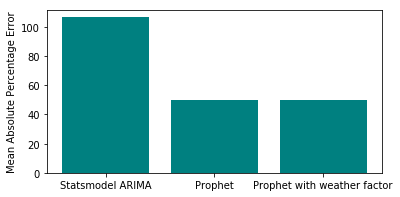

In [83]:
plt.figure(figsize=(6, 3))
plot_df = pd.DataFrame({'model':['Statsmodel ARIMA', 'Prophet', 'Prophet with weather factor'],
                       'val': [mape_arima, mape_prophet, mape_prophet_weather]})
plt.bar(plot_df['model'], plot_df['val'])
plt.ylabel('Mean Absolute Percentage Error')

### Save Model to Model Catalog

We are now going to save the our time series model trained on Prophet with weather factor included in the Model Catalog.  First let's prepare the model artifacts.

In [84]:
from ads.catalog.model import ModelSummaryList, ModelCatalog


In [86]:
from ads.common.model_export_util import prepare_generic_model
import joblib

path_to_generic_model_artifact = "/home/datascience/block_storage/generic_model"
!mkdir /home/datascience/block_storage/generic_model

joblib.dump(prophet_weather, path_to_generic_model_artifact + "/model.pkl")
generic_model_artifact = prepare_generic_model(path_to_generic_model_artifact)

### Here is a list of our model artifacts

In [87]:
!ls /home/datascience/block_storage/generic_model

fn-model  model.pkl  requirements.txt  score.py


The first file is `score.py`. This Python module includes the functions needed to load the model to memory (`load_model()`) and make predictions (`predict()`). 

In [88]:
!cat /home/datascience/block_storage/generic_model/score.py

import json
import os




"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = None
    model = None
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    # if model_file_name in contents:
    #    with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
    #        model = cloudpickle.load(file) # Use the loader corresponding to your model file.
    # else:
    #    raise Exception('{0} is not found in model directory {1}'.format(mod

### After the model artifacts are prepared, we can save it in the Model Catalog

In [89]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ["PROJECT_OCID"]

# Saving the model artifact to the model catalog: 
prophet_time_series_model = generic_model_artifact.save(project_id=project_id, compartment_id=compartment_id, display_name="Prophet_Time_Series",
                                 description="Prophet Time Series Model", training_script_path="demo.ipynb", ignore_pending_changes=True)
prophet_time_series_model

INFO:oci.base_client.140711745450560: 2020-03-05 00:28:25.617426: Request: POST https://datascience.us-ashburn-1.oci.oraclecloud.com/20190101/models
INFO:oci.base_client.140711745450560: 2020-03-05 00:28:25.999063: Request: POST https://datascience.us-ashburn-1.oci.oraclecloud.com/20190101/models/ocid1.datasciencemodel.oc1.iad.amaaaaaanif7xwia3j6p7ccrvhdjnspurjzbagg4we55pb5r6ac7i4ep5n3q/artifact
INFO:oci.base_client.140711745450560: 2020-03-05 00:28:26.888604: Request: GET https://datascience.us-ashburn-1.oci.oraclecloud.com/20190101/models/ocid1.datasciencemodel.oc1.iad.amaaaaaanif7xwia3j6p7ccrvhdjnspurjzbagg4we55pb5r6ac7i4ep5n3q
INFO:oci.base_client.140711745450560: 2020-03-05 00:28:26.938849: Request: GET https://datascience.us-ashburn-1.oci.oraclecloud.com/20190101/models/ocid1.datasciencemodel.oc1.iad.amaaaaaanif7xwia3j6p7ccrvhdjnspurjzbagg4we55pb5r6ac7i4ep5n3q/provenance
INFO:oci.base_client.140711745450560: 2020-03-05 00:28:26.989295: Request: POST https://datascience.us-ashburn

,
id,ocid1.datasciencemodel.oc1.iad.amaaaaaanif7xwia3j6p7ccrvhdjnspurjzbagg4we55pb5r6ac7i4ep5n3q
compartment_id,ocid1.compartment.oc1..aaaaaaaafl3avkal72rrwuy4m5rumpwh7r4axejjwq5hvwjy4h4uoyi7kzyq
project_id,ocid1.datascienceproject.oc1.iad.amaaaaaanif7xwiabrkuqsxyfqyhu6zki7nldjpzor6zrjhffh7qli2dxpuq
display_name,Prophet_Time_Series
description,Prophet Time Series Model
lifecycle_state,ACTIVE
time_created,2020-03-05 00:28:25.895000+00:00
created_by,ocid1.user.oc1..aaaaaaaagmjymomikkyltl4uddkeeujug5o2f4ssa5ifybrxar73pcb5d7ya
freeform_tags,{}
defined_tags,{}
